### 0.1 READ THE DATA SOURCE

In [3]:
import configparser

# initiate the configparser
config = configparser.ConfigParser()

# Read the Config ini file
config.read('config.ini')

# Access the file path
csv_file_path = config['path']['farmer_advisor']

### 0.2 DEFINE THE HTML DISPLAY

In [4]:
from IPython.display import display, HTML
import pandas as pd

# Define the CSS that will make the table scrollable
css = """
.output {
    max-height: 500px; /* Adjust as needed */
    overflow: scroll;  /* Allows scrolling */
}
"""

# Apply the CSS for scrollable output
display(HTML('<style>{}</style>'.format(css)))

# Configure pandas display options for better visuals
pd.set_option('display.max_rows', None)  # Display all rows, adjust as needed
pd.set_option('display.max_columns', None)  # Display all columns, adjust as needed
pd.set_option('display.max_colwidth', 90)  # Set max column width for long text
pd.options.display.float_format = '{:,.2f}'.format  # Format floating-point numbers

_____________

### 1. DATA EXPOSURE

In [5]:
# Read the csv file
farmer_advisor = pd.read_csv(csv_file_path, encoding='UTF-8-SIG')

# Function to display data overview
def display_data (df, title):
    shape_info = f"<div><b>Shape:</b>{df.shape}</div>" #shape information
    summary_stats = df.describe().to_html() # summary statistics
    data_types = df.dtypes.to_frame().to_html() # data type disclosure

    # Display title, table, data types, summary statistics and complete dataset
    display(HTML(f"<h2>{title}</h2>"))
    display(HTML(shape_info))
    display(HTML(f"<div><b>Data Types:</b></div>"))
    display(HTML(data_types))
    display(HTML(f"<div><b>Summary Statistics:</b></div>"))
    display(HTML(summary_stats))
    display(HTML(f"<div><b>Complete Dataset:</b></div>"))
    display(HTML(df.to_html(index=False)))

# Display the function
display_data(farmer_advisor, "FARMER ADVISOR DATA OVERVIEW")



,0
Farm_ID,int64
Soil_pH,float64
Soil_Moisture,float64
Temperature_C,float64
Rainfall_mm,float64
Crop_Type,object
Fertilizer_Usage_kg,float64
Pesticide_Usage_kg,float64
Crop_Yield_ton,float64
Sustainability_Score,float64


,Farm_ID,Soil_pH,Soil_Moisture,Temperature_C,Rainfall_mm,Fertilizer_Usage_kg,Pesticide_Usage_kg,Crop_Yield_ton,Sustainability_Score
count,"10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"5,000.50",6.50,29.99,25.03,174.97,125.21,10.52,5.49,50.21
std,"2,886.90",0.57,11.49,5.77,72.86,43.13,5.54,2.61,28.67
min,1.00,5.50,10.00,15.00,50.03,50.01,1.00,1.00,0.00
25%,"2,500.75",6.00,20.03,20.08,111.79,87.95,5.68,3.22,25.97
50%,"5,000.50",6.50,29.86,24.96,174.47,125.19,10.62,5.49,50.23
75%,"7,500.25",6.99,40.05,30.05,237.81,162.62,15.33,7.74,74.94
max,"10,000.00",7.50,49.99,35.00,299.99,199.99,20.00,10.00,99.99


Farm_ID,Soil_pH,Soil_Moisture,Temperature_C,Rainfall_mm,Crop_Type,Fertilizer_Usage_kg,Pesticide_Usage_kg,Crop_Yield_ton,Sustainability_Score
1,7.07,49.15,26.67,227.89,Wheat,131.69,2.96,1.58,51.91
2,6.24,21.50,29.33,244.02,Soybean,136.37,19.20,3.82,47.16
3,5.92,19.47,17.67,141.11,Corn,99.73,11.04,1.13,50.15
4,6.85,27.97,17.19,156.79,Wheat,194.83,8.81,8.87,89.76
5,6.93,33.64,23.60,77.86,Corn,57.27,3.75,8.78,51.03
6,6.13,15.94,30.45,296.62,Rice,96.48,3.27,2.04,23.03
7,7.41,41.56,25.77,54.35,Soybean,159.21,13.67,6.18,88.87
8,7.02,35.17,22.72,292.36,Soybean,180.44,18.57,5.22,44.02
9,5.53,12.67,15.35,183.93,Wheat,191.53,3.24,7.80,80.16
10,6.27,13.36,23.03,199.65,Soybean,58.52,13.67,6.22,82.93


_________
### 2. DATA PREPARE


##### A. DEFINE AND APPLY A STANDARD CLEANING FUNCTION

In [6]:
# Define a standard cleaning function
def clean_dataset(df, dtype_mapping=None, index_col=None):
    """ 
    data cleaniing function

    Parameters
    1. df: Input DataFrame
    2. dtype_mapping: Dictionary of column: dtype for conversion
    3. index_col: Column to set as index

    Returns
    - cleaned display
    - Display cleaning report
    """

    # Initiate the cleaning report
    report ={
        'original_shape': df.shape,
        'duplicates_removed': 0,
        'missing_values': {},
        'type_changes': {},
        'index_set': None,
        'final_shape': None
    }

    # Create working copy
    df_clean =df.copy()

    # 1. Handle data type conversions
    if dtype_mapping:
        for col, dtype in dtype_mapping.items():
            if col in df_clean.columns:
                old_type = str(df_clean[col].dtype)
                df_clean[col] = df_clean[col].astype(dtype)
                new_type = str(df_clean[col].dtype)
                if old_type != new_type:
                    report['type_changes'][col] = f"{old_type} → {new_type}"

    # 2. Identify missing values and report only
    for col in df_clean.columns:
        missing = df_clean[col].isna().sum()
        if missing > 0:
            report ['missing_values'][col] = missing
        
    # 3. Remove duplicates
    duplicates = df_clean.duplicated().sum()
    df_clean.drop_duplicates(inplace=True)
    report['duplicates_removed'] = duplicates

    # 4. Set index if specified
    if index_col and index_col in df_clean.columns:
        df_clean.set_index(index_col, inplace=True)
        report['index_set'] = index_col 
    
    # Final metadata
    report['final_shape'] = df_clean.shape

    # Display report
    display_cleaning_report(report)

    return df_clean

def display_cleaning_report(report):
    """Display compact cleaning report"""
    html = """
    <style>
        .cleaning-report {
            font-family: Arial, sans-serif;
            border-collapse: collapse;
            width: 100%;
            margin-bottom: 20px;
        }
        .cleaning-report th {
            background-color: #f2f2f2;
            text-align: left;
            padding: 8px;
            border: 1px solid #ddd;
        }
        .cleaning-report td {
            padding: 8px;
            border: 1px solid #ddd;
        }
        .cleaning-report tr:nth-child(even) {
            background-color: #f9f9f9;
        }
    </style>
    <h3>Data Cleaning Report</h3>
    <table class="cleaning-report">
        <tr>
            <th>Operation</th>
            <th>Details</th>
        </tr>
    """
    
    # Basic stats
    html += f"""
        <tr>
            <td>Original Shape</td>
            <td>{report['original_shape']}</td>
        </tr>
        <tr>
            <td>Final Shape</td>
            <td>{report['final_shape']}</td>
        </tr>
        <tr>
            <td>Duplicates Removed</td>
            <td>{report['duplicates_removed']}</td>
        </tr>
    """
    
    # Missing values
    if report['missing_values']:
        html += """
        <tr>
            <td>Missing Values Found</td>
            <td>
        """
        for col, count in report['missing_values'].items():
            html += f"{col}: {count}<br>"
        html += "</td></tr>"
    
    # Type changes
    html += """
        <tr>
            <td>Data Type Changes</td>
            <td>
    """
    if report['type_changes']:
        for col, change in report['type_changes'].items():
            html += f"{col}: {change}<br>"
    else:
        html += "None"
    html += "</td></tr>"

    
    # Index setting
    if report['index_set']:
        html += f"""
        <tr>
            <td>Index Set</td>
            <td>{report['index_set']}</td>
        </tr>
        """
    
    html += "</table>"
    display(HTML(html))

In [9]:
# Define your type mapping
dtype_spec = {
    'Farm_ID':	'int64',
    'Soil_pH' : 'float64',
    'Soil_Moisture': 'float64',
    'Temperature_C':	'float64',
    'Rainfall_mm':	'float64',
    'Crop_Type':	'object',
    'Fertilizer_Usage_kg':'float64',
    'Pesticide_Usage_kg': 'float64',
    'Crop_Yield_ton': 'float64',
    'Sustainability _Score': 'float64'
}

# Clean the data
cleaned_df = clean_dataset(
    farmer_advisor,
    dtype_mapping=dtype_spec,
    index_col='Farm_ID'
)

Operation,Details
Original Shape,"(10000, 10)"
Final Shape,"(10000, 9)"
Duplicates Removed,0
Data Type Changes,None
Index Set,Farm_ID


##### B. CREATE DERIVED FIELDS TO OPTIMIZE ANALYSIS

In [10]:
# Define pH bins and lables
bins=[5.5, 6.0, 6.5, 7.0, 7.5]
labels= ['Acidic (5.5-6.0)', 
         'Moderately Acidic (6.0-6.5)',
         'Neutral (6.5-7.0)',
         'Alkaline (7.0-7.5)']

# Add a new column 'pH_Tier' to the DataFrame
farmer_advisor['pH_Tier'] = pd.cut(
    farmer_advisor['Soil_pH'],
    bins=bins,
    labels=labels,
    right=False # Ensures 6.0 is in "Moderately Acidic", not "Acidic"
)

# Verify the new column
display(HTML(f"<div><b>Step 1: Add pH Tiers to the DataFrame </div></b>"))
farmer_advisor[['Soil_pH', 'pH_Tier']].head()

,Soil_pH,pH_Tier
0,7.07,Alkaline (7.0-7.5)
1,6.24,Moderately Acidic (6.0-6.5)
2,5.92,Acidic (5.5-6.0)
3,6.85,Neutral (6.5-7.0)
4,6.93,Neutral (6.5-7.0)


In [11]:
# Define temp bins and labels
temp_bins = [15, 20,25, 30, 35]
temp_labels = ['Cool (<20°C)','Moderate (20-25°C)', 'Warm (25-30°C)', 'Hot(>30°C)']

# Add temperature tier column
farmer_advisor['Temp_Tier']=pd.cut(
    farmer_advisor['Temperature_C'],
    bins=temp_bins,
    labels=temp_labels,
    right=False
)

# Define rain bins and labels
Rain_bins = [50, 100, 200, 300]
Rain_labels = ["low (<100mm)", "Moderate (100-200mm)", "High (>200mm)"]

farmer_advisor['Rain_Tier']=pd.cut(
    farmer_advisor['Rainfall_mm'],
    bins=Rain_bins,
    labels=Rain_labels,
    right=False
)

display(HTML(f"<div><b>Step 2: Add Temperature and Rainfall Tiers to the DataFrame</div></b>"))
farmer_advisor[['Temperature_C', 'Temp_Tier', 'Rainfall_mm', 'Rain_Tier']].head()

,Temperature_C,Temp_Tier,Rainfall_mm,Rain_Tier
0,26.67,Warm (25-30°C),227.89,High (>200mm)
1,29.33,Warm (25-30°C),244.02,High (>200mm)
2,17.67,Cool (<20°C),141.11,Moderate (100-200mm)
3,17.19,Cool (<20°C),156.79,Moderate (100-200mm)
4,23.60,Moderate (20-25°C),77.86,low (<100mm)


In [12]:
# Define bins and lables for fertilizer/pesticide 
fert_bin = [50, 100, 150, 200]
fert_label = ["Low (50-100kg)", "Medium (100-150kg)", "High (>150kg)"]

pest_bin = [1, 5, 10, 20]
pest_label = ["Low (1-5kg)", "Medium (5-10kg)", "High (>10kg)"]

# Add Tier columns
farmer_advisor['Fertilizer_Tier'] = pd.cut(farmer_advisor['Fertilizer_Usage_kg'],
                                           bins=fert_bin,
                                           labels=fert_label,
                                           right=False)

farmer_advisor['Pesticide_Tier'] = pd.cut(farmer_advisor['Pesticide_Usage_kg'],
                                          bins=pest_bin,
                                          labels=pest_label,
                                          right=False)

# Show
display(HTML(f"<div><b>Step 3: Create Tiers for Fertilizer & Pesticide Usage</b></div>"))
farmer_advisor[['Fertilizer_Usage_kg', 'Fertilizer_Tier', 'Pesticide_Usage_kg', 'Pesticide_Tier']].head()

,Fertilizer_Usage_kg,Fertilizer_Tier,Pesticide_Usage_kg,Pesticide_Tier
0,131.69,Medium (100-150kg),2.96,Low (1-5kg)
1,136.37,Medium (100-150kg),19.20,High (>10kg)
2,99.73,Low (50-100kg),11.04,High (>10kg)
3,194.83,High (>150kg),8.81,Medium (5-10kg)
4,57.27,Low (50-100kg),3.75,Low (1-5kg)


_______________
### 3. DISCOVERY QUESTIONS

##### A. HOW DOES SOIL PH INFLUENCE CROP YIELD?


In [28]:
# Group by pH_Tier and calculate yield statistics
yield_by_ph = farmer_advisor.groupby('pH_Tier',
                                     observed=False)[('Crop_Yield_ton')].agg(['mean', 'median', 'count']).rename(columns={
    'mean':'Avg_Yield (ton)',
    'median': 'Median_Yield (ton)',
    'count': 'Farms_Count'
    }).round(2) 

# Display the HTML table
display(HTML(f"<div><b>Aggregate Crop Yield by pH Tier.</div></b>"))
display(HTML(yield_by_ph.to_html()))

,Avg_Yield (ton),Median_Yield (ton),Farms_Count
pH_Tier,,,
Acidic (5.5-6.0),5.47,5.49,2480
Moderately Acidic (6.0-6.5),5.51,5.45,2540
Neutral (6.5-7.0),5.45,5.37,2500
Alkaline (7.0-7.5),5.53,5.61,2480


In [29]:
# Group by pH_Tier and Crop_Type
yield_by_ph_crop = farmer_advisor.groupby(['pH_Tier','Crop_Type'], observed=True)['Crop_Yield_ton'].mean().unstack().round(2)

display(HTML(f"<div><b>Compare Yield by pH Tier and Crop Type</div></b>"))
HTML(yield_by_ph_crop.to_html())

Crop_Type,Corn,Rice,Soybean,Wheat
pH_Tier,,,,
Acidic (5.5-6.0),5.58,5.56,5.50,5.28
Moderately Acidic (6.0-6.5),5.67,5.49,5.40,5.47
Neutral (6.5-7.0),5.36,5.55,5.57,5.29
Alkaline (7.0-7.5),5.52,5.52,5.40,5.70


##### B. HOW DO RAINFALL AND TEMPERATURE VARIATIONS CORREALATE WITH CROP YIELD?

In [30]:
# Group by Temp_Tier 
yield_by_temp = farmer_advisor.groupby(['Temp_Tier'], 
                    observed=True)['Crop_Yield_ton'].agg(['mean','count']).round(2).rename(columns=
                    {'mean':'Avg_Yield_ton','count':'Farm_Count'
    })

display(HTML(f"<div><b>Analyze Yield by Temperature</div></b>"))
HTML(yield_by_temp.to_html())


,Avg_Yield_ton,Farm_Count
Temp_Tier,,
Cool (<20°C),5.59,2445
Moderate (20-25°C),5.52,2575
Warm (25-30°C),5.45,2452
Hot(>30°C),5.41,2528


In [31]:
# Group by crop type
yield_by_rain_crop = farmer_advisor.groupby(['Temp_Tier', 'Crop_Type'], observed=True)['Crop_Yield_ton'].mean().unstack().round(2)
HTML(yield_by_rain_crop.to_html())

Crop_Type,Corn,Rice,Soybean,Wheat
Temp_Tier,,,,
Cool (<20°C),5.73,5.57,5.58,5.48
Moderate (20-25°C),5.56,5.59,5.53,5.39
Warm (25-30°C),5.43,5.52,5.38,5.45
Hot(>30°C),5.40,5.44,5.40,5.39


In [32]:
# Group by Rain_Tier
yield_by_rain = farmer_advisor.groupby([ 'Rain_Tier'], 
                    observed=True)['Crop_Yield_ton'].agg(['mean','count']).round(2).rename(columns=
                    {'mean':'Avg_Yield_ton','count':'Farm_Count'
    })

display(HTML(f"<div><b>Analyze Yield by Rainfall</div></b>"))
HTML(yield_by_rain.to_html())

,Avg_Yield_ton,Farm_Count
Rain_Tier,,
low (<100mm),5.50,2043
Moderate (100-200mm),5.48,3930
High (>200mm),5.49,4027


In [33]:
# Group by crop type
yield_by_rain_crop = farmer_advisor.groupby(['Rain_Tier', 'Crop_Type'], observed=True)['Crop_Yield_ton'].mean().unstack().round(2)
HTML(yield_by_rain_crop.to_html())

Crop_Type,Corn,Rice,Soybean,Wheat
Rain_Tier,,,,
low (<100mm),5.56,5.45,5.52,5.48
Moderate (100-200mm),5.50,5.55,5.48,5.39
High (>200mm),5.56,5.55,5.43,5.44


#### C. WHAT ARE THE AVERAGE FERTILIZER/PESTICIDE USAGE PER CROP TYPE?

In [34]:
# Group by Crop_Type and calucalate fertilizer and pesticide average
crop_usage = (
    farmer_advisor
    .groupby('Crop_Type', observed=True)
    .agg(
        Avg_Fertilizer_kg=('Fertilizer_Usage_kg', 'mean'),
        Avg_Pesticide_kg= ('Pesticide_Usage_kg', 'mean'),
        Avg_Yield=('Crop_Yield_ton', 'mean'),
        Farms_Count=('Crop_Type', 'count')
    ).round(2)
)

HTML(crop_usage.to_html())


,Avg_Fertilizer_kg,Avg_Pesticide_kg,Avg_Yield,Farms_Count
Crop_Type,,,,
Corn,125.97,10.32,5.53,2455
Rice,125.23,10.57,5.53,2464
Soybean,124.21,10.54,5.47,2559
Wheat,125.48,10.65,5.43,2522


#### D. HOW DO FERTILIZER/PESTICIDE USAGE IMPACT SUSTAINIBILITY SCORES?

In [36]:
# Calculate sustainability mean per tier
fert_sustainiability = (
    farmer_advisor.groupby(['Fertilizer_Tier'], observed=True)
['Sustainability_Score']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'Avg_Sustainability',
                     'count':'Farm_Count'}).round(2)
)

pest_sustainability = (
    farmer_advisor.groupby(['Pesticide_Tier'],observed=True)
['Sustainability_Score']
    .agg(['mean','count'])
    .rename({'mean':'Avg_Sustainability',
         'count':'Farm_Count'}).round(2)
)

display(HTML(f"<div><b>Analyze Sustainibility Scores by Tiers</b></div>"))
display(HTML(fert_sustainiability.to_html()))
display(HTML(pest_sustainability.to_html()))

,Avg_Sustainability,Farm_Count
Fertilizer_Tier,,
Low (50-100kg),49.74,3309
Medium (100-150kg),50.53,3353
High (>150kg),50.36,3338


,mean,count
Pesticide_Tier,,
Low (1-5kg),50.96,2160
Medium (5-10kg),50.06,2550
High (>10kg),49.99,5290


_________
### 4. DATA VISUALIZE

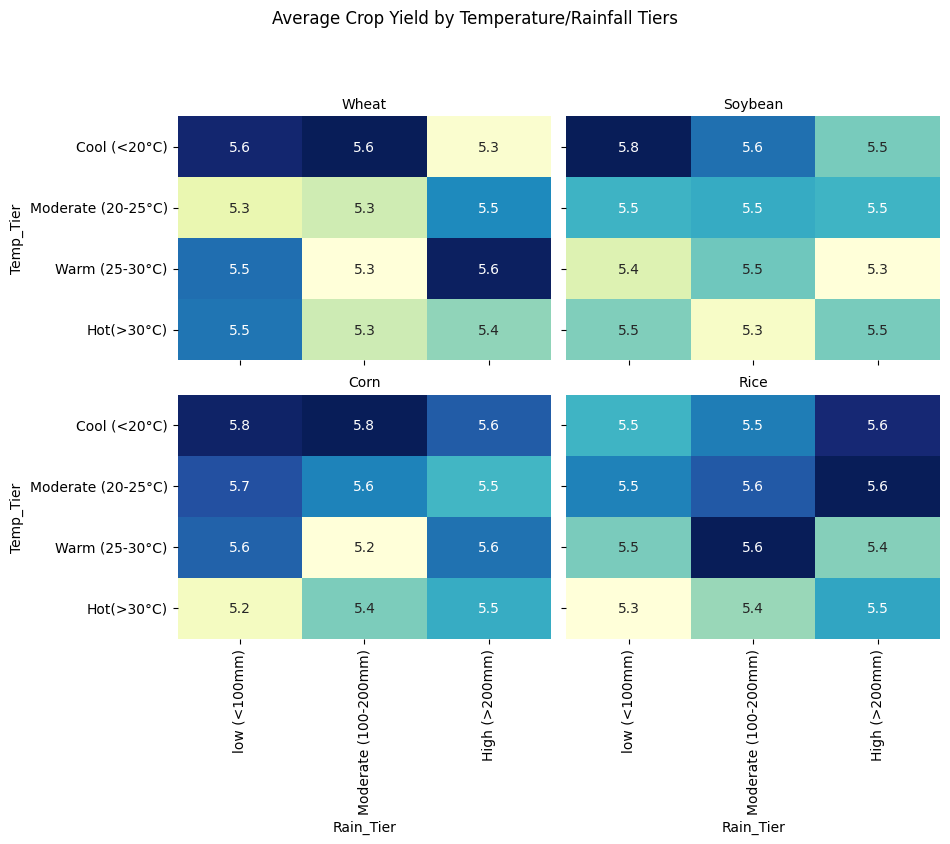

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a faceted grid of heatmaps
g = sns.FacetGrid(
    data=farmer_advisor,
    col='Crop_Type',  # Separate by crop
    col_wrap=2,       # 2 columns per row
    height=4,         # Height of each subplot
    aspect=1.2        # Width/height ratio
)

# Map heatmaps to each crop
g.map_dataframe(
    lambda data, **kwargs: sns.heatmap(
        data.pivot_table(
            index='Temp_Tier',
            columns='Rain_Tier',
            values='Crop_Yield_ton',
            aggfunc='mean',
            observed=True
        ),
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        cbar=False,  # Avoid duplicate colorbars
        **kwargs
    )
)

# Adjust layout
g.set_titles("{col_name}")
g.fig.suptitle("Average Crop Yield by Temperature/Rainfall Tiers", y=1.05)
plt.tight_layout()
plt.show()

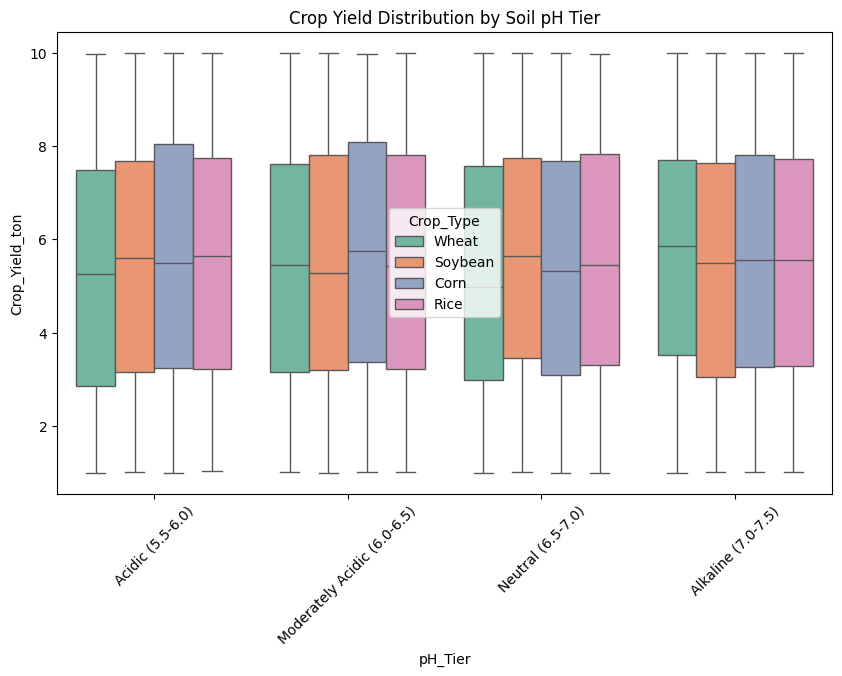

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=farmer_advisor,
    x='pH_Tier',
    y='Crop_Yield_ton',
    hue='Crop_Type',  # Optional: Compare crops
    palette="Set2"
)
plt.title("Crop Yield Distribution by Soil pH Tier")
plt.xticks(rotation=45)
plt.show()


Text(0, 0.5, 'Usage (kg)')

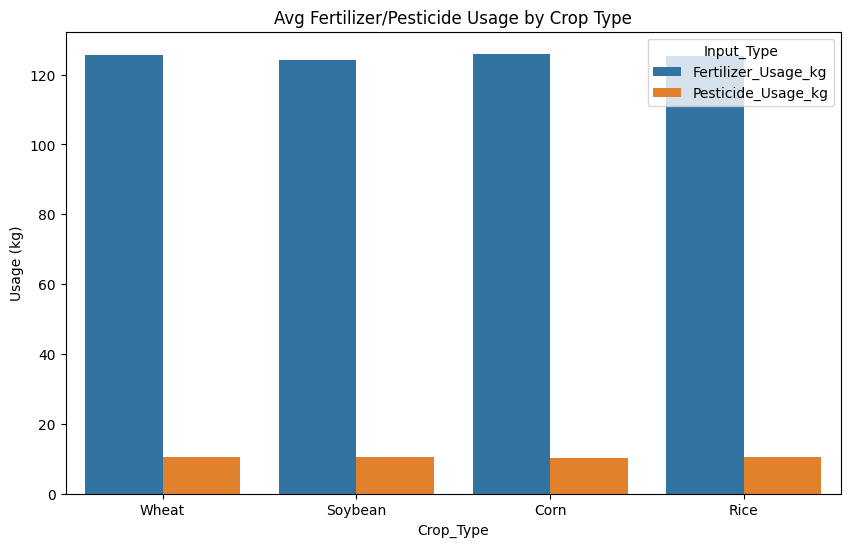

In [19]:
# Melt data for plotting
melted = farmer_advisor.melt(
    id_vars='Crop_Type',
    value_vars=['Fertilizer_Usage_kg', 'Pesticide_Usage_kg'],
    var_name='Input_Type',
    value_name='Usage_kg'
)

# Grouped bars
plt.figure(figsize=(10, 6))
sns.barplot(
    data=melted,
    x='Crop_Type',
    y='Usage_kg',
    hue='Input_Type',
    estimator='mean',
    errorbar=None
)
plt.title("Avg Fertilizer/Pesticide Usage by Crop Type")
plt.ylabel("Usage (kg)")

Text(0.5, 1.0, 'Sustainability Score Distribution by Pesticide Tiers')

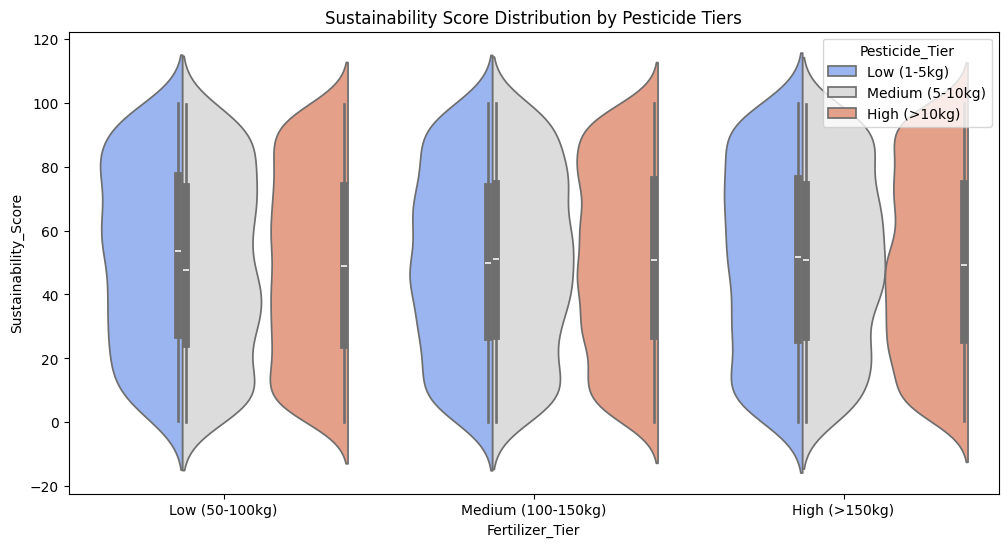

In [22]:
# Violin plot (distribution by tier)
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=farmer_advisor,
    x='Fertilizer_Tier',
    y='Sustainability_Score',
    hue='Pesticide_Tier',
    split=True,
    palette="coolwarm"
)
plt.title("Sustainability Score Distribution by Pesticide Tiers")
